<a href="https://colab.research.google.com/github/tayyab5838/langgraph_projects/blob/main/projects/travel_planer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
%pip install --q -U langchain_core langgraph langchain-google-genai python-dotenv

In [36]:
from typing_extensions import TypedDict, List, Annotated
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from IPython.display import display, Image


In [37]:
from google.colab import userdata
import os
os.environ['GEMINI_API_KEY'] = userdata.get('GEMNI_API_KEY')

### Define Agent State

In [38]:
class PlannerState(TypedDict):
  messages: Annotated[List[HumanMessage | AIMessage], "Conversation Messages"]
  city: str
  interests: List[str]
  itinerary: str

### Setup language Model and Prompts

In [39]:
import os
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=os.environ['GEMINI_API_KEY'])

tinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary. Don't ask follow up questions just give general answer. keep your answer short."),
    ("human", "Create an itinerary for my day trip."),
])

### Define Agents

In [40]:
def input_city(state: PlannerState) -> PlannerState:
  print("What city would you like to visit?")
  user_city = input("Your Input")
  return {
      **state,
      "city": user_city,
      "messages": state["messages"] + [HumanMessage(content=user_city)],
  }

def input_interest(state: PlannerState) -> PlannerState:
  print(f"Please enter your interests for the trip to {state['city']} (comma-separated):")
  user_interests = input("Your Input")
  return {
      **state,
      "interests": user_interests.split(","),
      "messages": state["messages"] + [HumanMessage(content=user_interests)],
  }

def create_itinerary(state: PlannerState) -> PlannerState:
  print(f"Creating Itinerary for {state['city']} based on interest: {', '.join(state['interests'])} ...")
  response = llm.invoke(tinerary_prompt.format_prompt(city=state["city"], interests=", ".join(state["interests"])))
  print("\n Final Itinerary")
  print(response.content)
  return {
      **state,
      "itinerary": response.content,
      "messages": state["messages"] + [AIMessage(content=response.content)],
  }

### Create and Compile the Graph

In [41]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_city", input_city)
workflow.add_node("input_interest", input_interest)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_city")

workflow.add_edge("input_city", "input_interest")
workflow.add_edge("input_interest", "create_itinerary")
workflow.add_edge("create_itinerary", END)

app = workflow.compile()

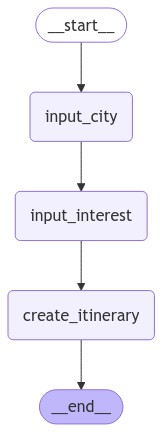

In [42]:
display(Image(app.get_graph().draw_mermaid_png()))

### Define the function that run the graph

In [43]:
def run_travel_planner(user_input: str):
  print(f"Initial Request: ", {user_input})
  state = {
      "messages": [HumanMessage(content=user_input)],
      "city": "",
      "interests": [],
      "itinerary": "",
  }
  for output in app.stream(state):
    pass # The nodes themselves now handle all the printing

In [44]:
user_request = "I want to plan a day trip"
run_travel_planner(user_request)

Initial Request:  {'I want to plan a day trip'}
What city would you like to visit?
Your Inputcalifornia
Please enter your interests for the trip to california (comma-separated):
Your Inputtech networking, exploring 
Creating Itinerary for california based on interest: tech networking,  exploring  ...

 Final Itinerary
* **Morning:** Start your day at the Tech Museum of Innovation in San Jose for interactive exhibits and tech talks. 
* **Lunch:** Grab lunch at a trendy cafe in the nearby Santana Row, known for its upscale shopping and dining scene.
* **Afternoon:** Head to the Computer History Museum in Mountain View to explore the evolution of computing.
* **Evening:**  Enjoy dinner at a Silicon Valley restaurant with a focus on innovative cuisine.  

